In [1]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys

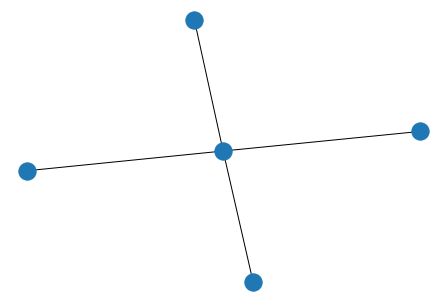

In [2]:
G = nx.star_graph(4)
h = np.zeros(len(G.nodes.keys()))


nx.draw(G)

In [3]:

def projection_simplex_pivot(v, z=1, random_state=None):
    rs = np.random.RandomState(random_state)
    n_features = len(v)
    U = np.arange(n_features)
    s = 0
    rho = 0
    while len(U) > 0:
        G = []
        L = []
        k = U[rs.randint(0, len(U))]
        ds = v[k]
        for j in U:
            if v[j] >= v[k]:
                if j != k:
                    ds += v[j]
                    G.append(j)
            elif v[j] < v[k]:
                L.append(j)
        drho = len(G) + 1
        if s + ds - (rho + drho) * v[k] < z:
            s += ds
            rho += drho
            U = L
        else:
            U = G
    theta = (s - z) / float(rho)
    return np.maximum(v - theta, 0)


def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


def crit_b(J):
    eigenvalues,_ = np.linalg.eig(J)
    return 1./np.max(np.abs(eigenvalues))

def average_degree(control):
    return np.sum([G.degree[i]*con for i,con in enumerate(control)])


In [5]:
        
class mf_ising_system:

    def __init__(self,graph,background_field,fixed_point_iter=int(5*1e4),init_mag='aligned',fp_tol_fac=10-6,
        iim_iter=1000,step_size=1.0,iim_tol_fac=1e-5):
        
        self.graph = graph
        self.adj_matrix = nx.to_numpy_matrix(graph)
        self.graph_size = len(graph.nodes.keys())
        self.background_field = background_field
        self.fixed_point_iter=fixed_point_iter
        self.iim_iter = iim_iter
        self.fp_tol_fac=fp_tol_fac
        self.iim_tol_fac=iim_tol_fac
        self.step_size=step_size
        if init_mag=='aligned':
            self.init_mag=np.ones(self.graph_size)
        else:
            self.init_mag = init_mag 
            
        
    def single_mag(self,i,m,beta,field):
        gamma=1.0
        spin_field = np.dot(self.adj_matrix[i],m) # TODO: IS THIS CORRECT?
        term = math.tanh(beta*(spin_field+field[i]))
        return (1.0-gamma)*m[i] + gamma*term
    
    def magnetisation(self,mag,beta,field):
        m_old = mag
        m_new = np.zeros(len(m_old))
        for i in range(system.graph_size):
            m_new[i]=system.single_mag(i,m_old,beta,field)
        return m_new

    def Steffensen_method(self,mag,beta,field,mag_delta_history,it):      
        # Numerical Analysis Richard L.Burden 9th Edition, p. 107
        
        if len(mag_delta_history)==0:
            mag0=mag
        else:
            mag0=mag_delta_history[it]
        
        for i in range(self.fixed_point_iter):     
            mag1=self.magnetisation(mag0,beta,field)
            mag2=self.magnetisation(mag1,beta,field)   

            if np.all((mag+mag2-2*mag1)!=0):
                mag_d = mag - (mag1-mag)**2/(mag+mag2-2*mag1) 
            else:
                mag_d = mag1
            
            if abs(np.mean(mag1)-np.mean(mag_d))<self.fp_tol_fac: 
                break
            if i+1==self.fixed_point_iter:
                print('Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter')
                mag_d = mag1
                
        mag_delta_history.append(mag_d)
        return mag_d,mag_delta_history
    
    def mag_grad(self,beta,mag):
        # Mean Field Susceptibility;
        
        if all([math.isclose(i,j,abs_tol=1e-5) for i,j in zip(mag,np.ones(len(mag)))]):
            gradient = np.zeros(len(mag))
        else:
            D=np.identity(self.graph_size)*np.array([(1-i**2) for i in mag]) # equals to 0 if all m's are 1 or close to 1
            inv = np.linalg.inv(np.identity(self.graph_size)-beta*D*self.adj_matrix)
            susc_matrix = beta*inv*D
            gradient = np.sum(susc_matrix,axis=1).A1
            gradient = (1.0 / np.linalg.norm(gradient))*gradient #Normalise

        return gradient
    
    
    def MF_IIM(self,field_budget,beta,init_control_field='uniform'):
              
        if init_control_field=='uniform':
            control_field = (field_budget/self.graph_size)*np.ones(self.graph_size)
        else:
            control_field = init_control_field

        # initial magnetisation as influenced by initial budget spread
        # note: different from init_mag which denotes initial magnetisation *without* the external field      
        tot_field = np.array(self.background_field+control_field)

        control_field_history=[]
        control_field_history.append(control_field)
        mag_delta_history=[]
        
        mag_i,mag_delta_history = self.Steffensen_method(self.init_mag,beta,tot_field,mag_delta_history,0)
        
        for it in range(self.iim_iter):
            mag_i_grad = self.mag_grad(beta,mag_i)
            control_field = control_field_history[it]

            control_field_update = (control_field - self.step_size*mag_i_grad)

            control_field_new = -projection_simplex_sort(control_field_update.T,z=field_budget)

            
            tot_field = np.array(self.background_field+control_field_new)
            mag_ii,mag_delta_history = self.Steffensen_method(mag_i,beta,tot_field,mag_delta_history,it)


            if np.abs(np.mean(mag_ii)-np.mean(mag_i)) <= self.iim_tol_fac:
                break
            control_field_history.append(control_field_new)
            mag_i=mag_ii
        if it==self.iim_iter-1:
            #print('Failed to converge after {} iterations'.format(self.iim_iter))
            
        return control_field,it
            
        
                
budget=1.0
h = np.zeros(len(G.nodes.keys()))

system = mf_ising_system(G,h,iim_iter=5000,fixed_point_iter=int(5*1e4))


beta_crit=crit_b(system.adj_matrix)
beta = 0.9
print(beta_crit)
control,it=system.MF_IIM(budget,beta)


0.5
Failed to converge after 5000 iterations


In [21]:
exp_beta_list = np.logspace(-0.7, 0.5, endpoint=True,num=100)
y = np.zeros(len(exp_beta_list))
control_history=[]
for i,beta in enumerate(exp_beta_list):
    system = mf_ising_system(G,h,iim_iter=10000,step_size=2.0,fp_tol_fac=10-4)
    control,_=system.MF_IIM(budget,beta)
    control_history.append(control)
    if i%10==0:
        print(i,beta)

print('FINISHED')    

0 0.19952623149688797
10 0.2637619356140949
20 0.3486777560873194
30 0.4609314733266289
40 0.6093242812135427
Failed to converge after 10000 iterations
50 0.8054908400956683
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
60 1.0648114862349343
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed to converge after 10000 iterations
Failed

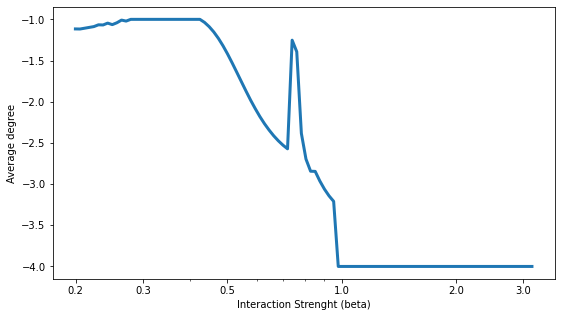

In [22]:


import matplotlib


avs_deg=np.zeros(len(control_history))
for it,control in enumerate(control_history):
    average_degree = np.sum([G.degree[i]*con for i,con in enumerate(control)])
    avs_deg[it]=average_degree

fig,ax = plt.subplots(figsize=(9,5))

ax.plot(exp_beta_list,avs_deg,linewidth=3)
ax.set_xscale(value='log')


ax.set_xticks([0.2,0.3,0.5,1.0,2.0, 3.0])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.set_xlabel(r'Interaction Strenght (beta)')
plt.show()


[array([-0.03875134, -0.24031217, -0.24031217, -0.24031217, -0.24031217]),
 array([-0.03908571, -0.24022857, -0.24022857, -0.24022857, -0.24022857]),
 array([-0.03583088, -0.24104228, -0.24104228, -0.24104228, -0.24104228]),
 array([-0.03257087, -0.24185728, -0.24185728, -0.24185728, -0.24185728]),
 array([-0.02930828, -0.24267293, -0.24267293, -0.24267293, -0.24267293]),
 array([-0.02210042, -0.24447489, -0.24447489, -0.24447489, -0.24447489]),
 array([-0.02267827, -0.24433043, -0.24433043, -0.24433043, -0.24433043]),
 array([-0.01524347, -0.24618913, -0.24618913, -0.24618913, -0.24618913]),
 array([-0.02133259, -0.24466685, -0.24466685, -0.24466685, -0.24466685]),
 array([-0.01377232, -0.24655692, -0.24655692, -0.24655692, -0.24655692]),
 array([-0.00301058, -0.24924736, -0.24924736, -0.24924736, -0.24924736]),
 array([-0.00698183, -0.24825454, -0.24825454, -0.24825454, -0.24825454]),
 array([-3.66204191e-05, -2.49990845e-01, -2.49990845e-01, -2.49990845e-01,
        -2.49990845e-01]

In [10]:
import torch
import torch.optim as optim
from itertools import permutations
from functools import reduce

possible_configs = np.zeros([2**system.graph_size,system.graph_size]) # possible spin configurations

init_mag = np.ones(system.graph_size)

def unique_permutations(iterable, r=None):
    previous = tuple()
    for p in permutations(sorted(iterable), r):
        if p > previous:
            previous = p
            yield p

all_pos,all_neg = np.ones(system.graph_size),(-1)*np.ones(system.graph_size)
for i,p in enumerate(unique_permutations(np.concatenate((all_pos,all_neg)),system.graph_size)):
    possible_configs[i]=p
    

def magnetic_int(i,m,h,beta):
    term = torch.exp(-beta*h[i]*m[i])
    return term

def magnetic_int_dev(i,m,h,beta):
    'Derivative of external magnetic field influence on i_th spin with respect to h_i'
    term = -beta*m[i]*magnetic_int(i,m,h,beta)
    return term

def magnetic_butI(system,i,m,h,beta):
    'external magnetic field influence term for all spins but i'
    iters=[j for j in range(system.graph_size) if j!=i]
    terms=torch.stack([magnetic_int(it,m,h,beta) for it in iters])
    term = reduce(lambda x, y: x*y,terms)
    return term

def magnetic_full(system,m,h,beta):
    term=torch.stack([magnetic_int_dev(i,m,h,beta)*magnetic_butI(system,i,m,h,beta) for i in range(system.graph_size)])
    return term 

def intermolar(system,m,beta):
    'calculates intermolar interaction in the partition function for a single configuration'
    adj_matrix=torch.from_numpy(system.adj_matrix)
    exp_term=torch.sum(torch.Tensor([float(m[i]*adj_matrix[i,:]@m) for i in range(system.graph_size)]))/2.0
    term = torch.exp(-beta*exp_term)
    return term
    
    
def partition_dev(system,h,beta):
    'Derivative of the partition function with respect to external field. dZ/dH'
    term=torch.stack([intermolar(system,m,beta)*magnetic_full(system,m,h,beta) for m in possible_configs])
    return torch.sum(term,axis=0)



def hamiltonian(system,m,h):
    adj_matrix=torch.from_numpy(system.adj_matrix)
    m = torch.from_numpy(m)
    x=torch.sum(torch.Tensor([float(m[i]*adj_matrix[i,:]@m) for i in range(system.graph_size)]))/2.0 + 2*h@m
    return x  


def partition_function(system,h,beta,possible_configs=possible_configs):
    term = torch.stack([torch.exp(-beta*hamiltonian(system,possible_configs[i],h)) for i in range(possible_configs.shape[0])])
    return torch.sum(term)


from torch.autograd import grad

def nth_derivative(f, wrt, n):
    for i in range(n):
        grads = -grad(f, wrt, create_graph=True)[0]
        f = grads.sum()
    return grads


def magnetisation(system,h,beta):
    term = (1/beta)*partition_dev(system,h,beta)* 1.0/(partition_function(system,h,beta))
    #term =(1/beta)*nth_derivative(partition_function(system,h,beta),h,1)* 1.0/(partition_function(system,h,beta))
    return term


def constrained_magnetisation(system,h,l,beta,budget):
    term = (1/beta)*1/(partition_function(system,h,beta)) * partition_dev(system,h,beta)+l*(torch.sum(h)-budget)
    return term

def projection_simplex_sort_torch(v, z=1):
    n_features = v.shape[0]
    indices,u = torch.sort(v,descending=True)[::-1]
    cssv = torch.cumsum(u,dim=0) - z
    ind = torch.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = v.clone()
    w.subtract_(theta)
    torch.nn.functional.relu(w, inplace=True)
    return w 



In [11]:
per_spin = (budget)/system.graph_size
H = per_spin*torch.ones(system.graph_size,dtype=torch.float64)
H.requires_grad=True


In [12]:
#beta=0.9
def theoretical_mag(beta,lr):
    epochs =10000
    per_spin = (budget)/system.graph_size
    H = per_spin*torch.ones(system.graph_size,dtype=torch.float64)
    H.requires_grad=True

    h_history=np.zeros((epochs,system.graph_size))
    g_history = np.zeros((epochs,system.graph_size))
    for i in range(epochs):
        output = -magnetisation(system,H,beta) # note the sign, so that it correspond to maximisation
        output.backward(torch.ones_like(H))
        H.data.add_(lr*H.grad.data)
        H.data = projection_simplex_sort_torch(H, z=budget)
        H.grad.detach_()
        H.grad.zero_()
        h_grad = H.grad.data.detach().numpy()
        g_history[i]=h_grad
        h_arr = H.detach().numpy()
        h_history[i]=h_arr
        assert np.round(np.sum(h_arr),3)==budget
        if np.sum(np.abs(h_arr-h_history[i-1])) <1e-8:
            break
        
        
    return H.detach().numpy(),h_history,i
    
tx,history,i = theoretical_mag(0.9,0.1)


# fig,ax=plt.subplots()
# ax.plot(h_history[:,0],label='nodeC')
# ax.plot(h_history[:,1],label='nodep1')
# ax.plot(h_history[:,2],label='nodep2')
# ax.plot(h_history[:,3],label='nodep3')
# #ax.plot(h_history[:,4],label='nodep4')

# ax.legend()


In [13]:

lr = 1.0
beta_list = np.linspace(0.2, 3.0, endpoint=True,num=300)
theoretic_arr = np.zeros((len(beta_list),system.graph_size))
for i,beta in enumerate(beta_list):
    tx,_,it = theoretical_mag(beta,lr)
    theoretic_arr[i]=tx
    if i%20==0:
        print(i,tx,'learning rate',lr,'iteration',it)
        lr = max(lr*0.5,0.01)
print('Finished')

0 [1. 0. 0. 0. 0.] learning rate 1.0 iteration 7
20 [1. 0. 0. 0. 0.] learning rate 0.5 iteration 4
40 [1. 0. 0. 0. 0.] learning rate 0.25 iteration 4
60 [1. 0. 0. 0. 0.] learning rate 0.125 iteration 10
80 [0.89058405 0.02735399 0.02735399 0.02735399 0.02735399] learning rate 0.0625 iteration 59
100 [0.8110539  0.04723652 0.04723652 0.04723652 0.04723652] learning rate 0.03125 iteration 70
120 [0.   0.25 0.25 0.25 0.25] learning rate 0.015625 iteration 17
140 [0.   0.25 0.25 0.25 0.25] learning rate 0.01 iteration 17
160 [0.   0.25 0.25 0.25 0.25] learning rate 0.01 iteration 14
180 [0.   0.25 0.25 0.25 0.25] learning rate 0.01 iteration 13
200 [0.   0.25 0.25 0.25 0.25] learning rate 0.01 iteration 13
220 [0.   0.25 0.25 0.25 0.25] learning rate 0.01 iteration 13
240 [0.   0.25 0.25 0.25 0.25] learning rate 0.01 iteration 14
260 [0.   0.25 0.25 0.25 0.25] learning rate 0.01 iteration 14
280 [0.   0.25 0.25 0.25 0.25] learning rate 0.01 iteration 15
Finished


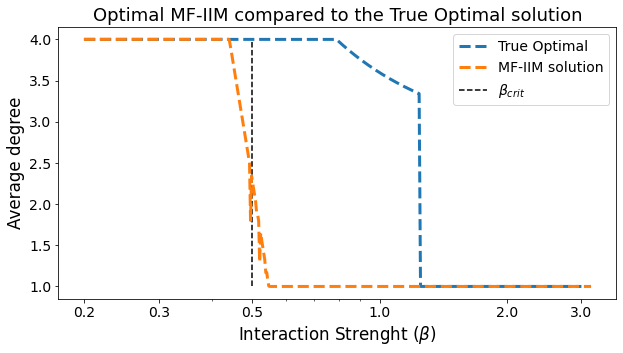

In [20]:
import matplotlib
avs_degrees=np.zeros(len(theoretic_arr))
for it,control in enumerate(theoretic_arr):
    average_degree = np.sum([G.degree[i]*con for i,con in enumerate(control)])
    avs_degrees[it]=average_degree

    
    
matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(10,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})


    
fig,ax = plt.subplots()

ax.plot(beta_list,avs_degrees,label='True Optimal',linestyle='dashed',linewidth=3)
ax.plot(exp_beta_list,avs_deg,label='MF-IIM solution',linestyle='dashed',linewidth=3)
ax.vlines(beta_crit,ymin=1,ymax=4,linestyles='dashed',color='black',label=r'$\beta_{crit}$')

ax.legend()
ax.set_xscale(value='log')
ax.set_title('Optimal MF-IIM compared to the True Optimal solution')

ax.set_xticks([0.2,0.3,0.5,1.0,2.0, 3.0])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.set_xlabel(r'Interaction Strenght ($\beta$)')
plt.show()

In [443]:
avs_degrees[111]

theoretic_arr[111]

array([0.78021313, 0.05494672, 0.05494672, 0.05494672, 0.05494672])

In [362]:

def free_energy(system,h,beta,possible_configs=possible_configs):
    F = -(1.0/beta)*torch.log(partition_function(system,h,beta))
    return F


free_energy(system,H,1.5,possible_configs=possible_configs)

tensor(-5.2706, dtype=torch.float64, grad_fn=<MulBackward0>)

In [95]:
per_spin = (budget)/system.graph_size
H = -per_spin*torch.ones(system.graph_size,dtype=torch.float64)
H.requires_grad=True


Z = partition_function(system,H,1.5)
dZdH = nth_derivative(partition_function(system,H,1.5),H, 1)
print(dZdH)

dZdH2 = partition_dev(system,H,1.5)
print(dZdH2)

tensor([-27.9548,  31.7175,  31.7175], dtype=torch.float64,
       grad_fn=<NegBackward>)
tensor([ 27.9548, -31.7175, -31.7175], dtype=torch.float64,
       grad_fn=<SumBackward1>)


In [137]:
# LANGRANGIAN 

epochs = 100
lr = 0.1
lr2=1.0
h_history=np.zeros((epochs,system.graph_size))
for i in range(epochs):
    
    output = -constrained_magnetisation(system,H,L,0.1,budget) # note the sign, so that it correspond to maximisation
    output.backward()
    
    H.data.add_(-lr*H.grad.data)
    H.grad.detach_()
    H.grad.zero_()
    
    L.grad.detach_()
    L.grad.zero_()
    
    output = -constrained_magnetisation(system,H,L,0.1,budget) 
    output.backward()
    
    L.data.add_(lr2*L.grad.data)
    H.grad.detach_()
    H.grad.zero_()

    L.grad.detach_()
    L.grad.zero_()
    

    h_arr = H.detach().numpy()
    h_history[i]=h_arr
    #assert np.round(np.sum(h_arr),3)==budget

NameError: name 'L' is not defined

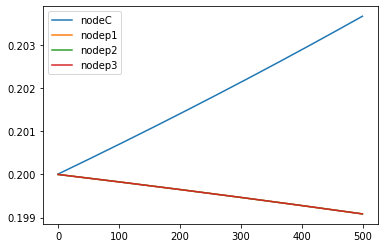

In [393]:
fig,ax=plt.subplots()
ax.plot(h_history[:,0],label='nodeC')
ax.plot(h_history[:,1],label='nodep1')
ax.plot(h_history[:,2],label='nodep2')
ax.plot(h_history[:,3],label='nodep3')
ax.legend()

In [401]:


spin_field = np.dot(system.adj_matrix[i],m)

print(spin_field)

[[-1.]]
